In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ema_workbench import (Model, RealParameter, ScalarOutcome)
from ema_workbench import MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim, dimensional_stacking

In [3]:
experiments, outcomes = load_results('./data/results.tar.gz')

In [4]:
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

In [5]:
outcomes_focus = outcomes.drop(columns=['All Costs'])

In [6]:
results = pd.concat([experiments, outcomes])

In [7]:
uncertainties = experiments.iloc[:, :19]
levers = experiments.iloc[:, 19:50]

In [8]:
X = uncertainties
y = outcomes_focus['Expected Number of Deaths']

In [9]:
Y = y < 0.8

In [10]:
prim_algorithm = prim.Prim(X, Y, threshold = 0.8)
box1 = prim_algorithm.find_box()

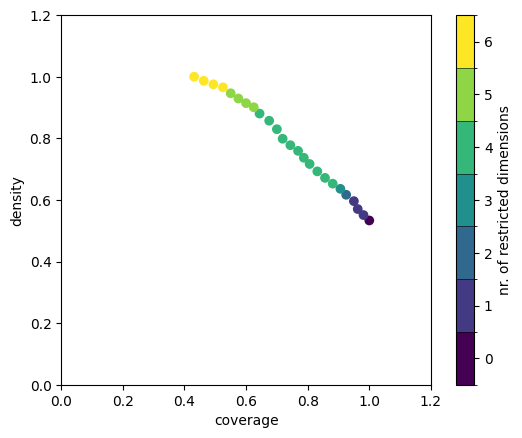

In [11]:
box1.show_tradeoff()
plt.show()

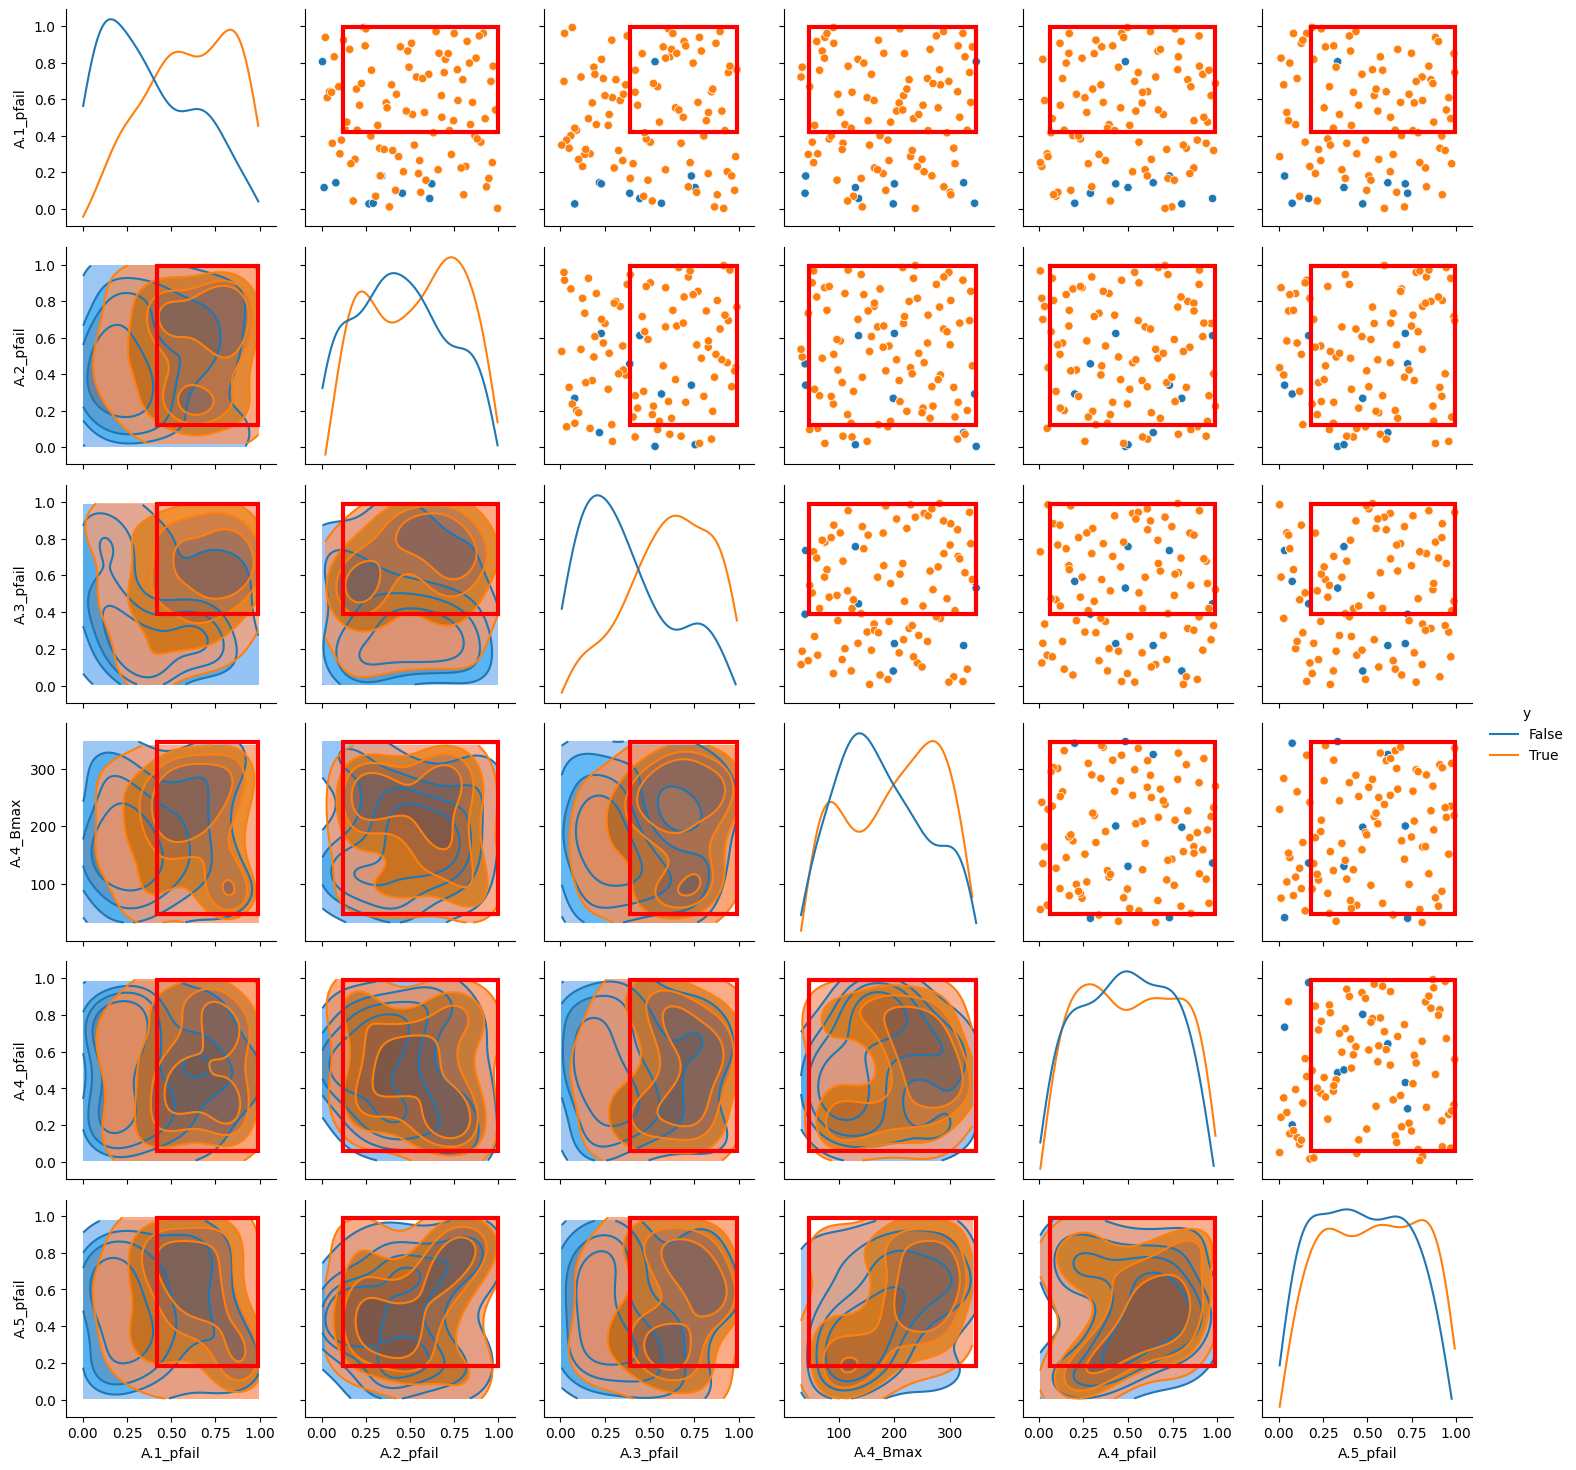

In [12]:
box1.show_pairs_scatter()
plt.show()

In [13]:
scenarios_of_interest = box1.peeling_trajectory
scenarios_of_interest = scenarios_of_interest[(scenarios_of_interest.coverage > 0.8) & (scenarios_of_interest.density > 0.6)]

In [14]:
scenarios_of_interest = scenarios_of_interest.sort_values(by='density', ascending=False)
scenarios_of_interest

,coverage,density,id,k,mass,mean,n,res_dim
9,0.80625,0.716667,9,129,0.60,0.716667,180,4
8,0.83125,0.692708,8,133,0.64,0.692708,192,4
7,0.85625,0.671569,7,137,0.68,0.671569,204,4
6,0.88125,0.652778,6,141,0.72,0.652778,216,4
5,0.90625,0.635965,5,145,0.76,0.635965,228,3
4,0.92500,0.616667,4,148,0.80,0.616667,240,2


In [16]:
chosen_box = scenarios_of_interest[scenarios_of_interest.density == scenarios_of_interest.density.max()]
chosen_box_id = int(chosen_box.iloc[0].name)
chosen_box_id

9

In [17]:
chosen_box

,coverage,density,id,k,mass,mean,n,res_dim
9,0.80625,0.716667,9,129,0.6,0.716667,180,4


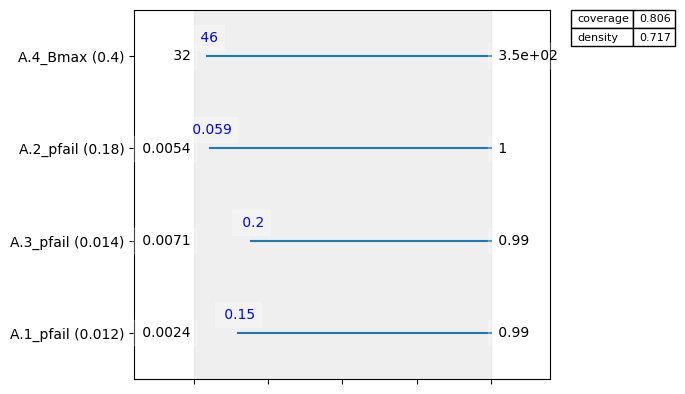

In [18]:
box1.select(chosen_box_id)
box1.inspect(style='graph')
plt.show()

In [19]:
# Inspect the parameter limits from the chosen box.
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.669291,"{1.5, 10.0, 1.0}",0.149735,31.338419,"{1.5, 10.0, 1.0}",0.059057,32.586132,"{1.5, 10.0, 1.0}",0.197341,46.368589,"{1.0, 10.0, 1.5}",0.009515,32.433860,"{1.0, 10.0, 1.5}",0.006091,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,348.582870,"{1.5, 10.0, 1.0}",0.992785,347.095651,"{1.5, 10.0, 1.0}",0.995438,347.994609,"{1.5, 10.0, 1.0}",0.990417,348.022511,"{1.0, 10.0, 1.5}",0.990703,349.231737,"{1.0, 10.0, 1.5}",0.991472,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
